In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.optimize import curve_fit
plt.style.use("seaborn-v0_8-darkgrid")

In [18]:
data_path = Path("asu.tsv")
df = pd.read_csv("asu.tsv", sep="\t", comment="#")
df.head()

,Cluster,Field,Cepheid,Dist,Per,HJD,Vmag,Imag,E(B-V),Type
0,,,,,d,d,mag,mag,mag,NaN
1,-------,--------,------,----,--------,-------------,------,------,------,--
2,LMC0005,LMC_SC15,45780,0.7,3.58788,2450723.23710,16.017,15.227,0.126,FU
3,LMC0038,LMC_SC14,109715,0.1,1.91300,2450723.27982,15.898,15.337,0.138,FO
4,LMC0051,LMC_SC14,160642,0.3,0.97211,2450724.94922,15.348,15.140,0.138,BR


In [19]:
# 1. How big is the table?
df.shape          # (rows, columns)

# 2. Do the columns look right / correct dtypes?
df.info()

# 3. Peek at the first few real rows
df.head(10)

# 4. Any obvious bad / missing values?
df.isna().sum()

# 5. Basic stats for the numeric columns (esp. Per and Vmag)
df[["Per", "Vmag"]].describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Cluster  206 non-null    object
 1   Field    206 non-null    object
 2   Cepheid  206 non-null    object
 3   Dist     206 non-null    object
 4   Per      206 non-null    object
 5   HJD      206 non-null    object
 6   Vmag     206 non-null    object
 7   Imag     206 non-null    object
 8   E(B-V)   206 non-null    object
 9   Type     205 non-null    object
dtypes: object(10)
memory usage: 16.2+ KB


,Per,Vmag
count,206,206
unique,194,183
top,0.40354,15.308
freq,2,4


In [21]:
# 1. choose numeric columns
num_cols = ["Per", "Vmag", "Imag", "E(B-V)"]

# 2. convert them from strings -> numbers
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# 3. check that it worked
df[num_cols].info()
df[num_cols].describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Per     204 non-null    float64
 1   Vmag    204 non-null    float64
 2   Imag    204 non-null    float64
 3   E(B-V)  204 non-null    float64
dtypes: float64(4)
memory usage: 6.6 KB


,Per,Vmag,Imag,E(B-V)
count,204.000000,204.000000,204.000000,204.000000
mean,4.478774,15.850598,15.128294,0.144113
std,4.841457,0.827237,0.749328,0.022313
min,0.403540,9.999000,13.056000,0.105000
25%,2.354130,15.512750,14.761000,0.121000
50%,3.375205,15.856000,15.122500,0.142000
75%,4.896888,16.214750,15.416000,0.152000
max,56.498190,18.870000,17.751000,0.201000


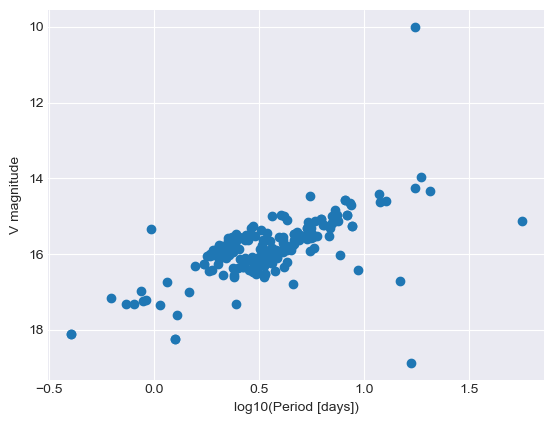

In [28]:
import numpy as np
import matplotlib.pyplot as plt   # if you haven't already

clean = df[num_cols].dropna()

plt.scatter(np.log10(clean["Per"]), clean["Vmag"])
plt.xlabel("log10(Period [days])")
plt.ylabel("V magnitude")
plt.gca().invert_yaxis()   # optional, makes brighter stars higher

-1.8155661143781132 16.833876258014456


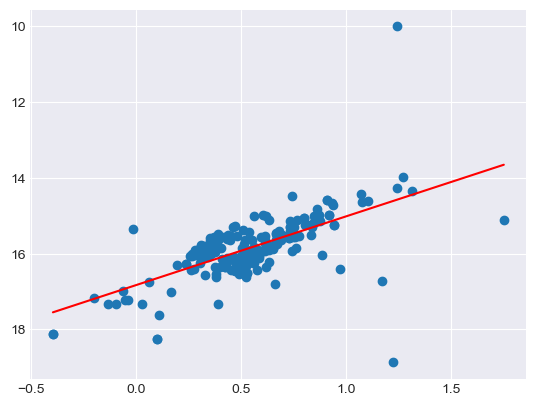

In [29]:
from scipy.optimize import curve_fit

def pl_model(logP, a, b):
    return a*logP + b

logP = np.log10(clean["Per"].values)
V    = clean["Vmag"].values

popt, pcov = curve_fit(pl_model, logP, V)
a, b = popt
print(a, b)

x = np.linspace(logP.min(), logP.max(), 200)
plt.scatter(logP, V)
plt.plot(x, pl_model(x, a, b), color="red")
plt.gca().invert_yaxis()

a = -1.8155661143781132 ± 0.1539719438932365
b = 16.833876258014456 ± 0.0946063818445925


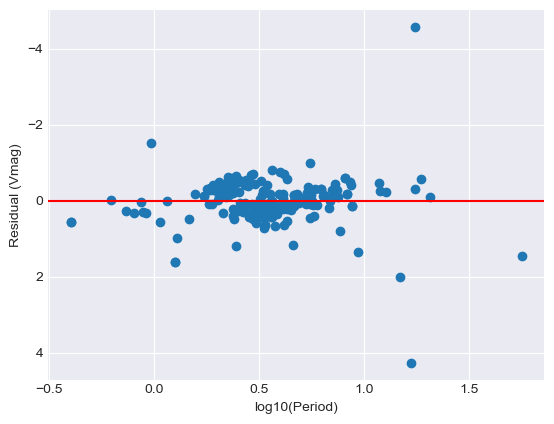

In [30]:
# 1. Uncertainties on a and b
import numpy as np
a_err, b_err = np.sqrt(np.diag(pcov))
print("a =", a, "±", a_err)
print("b =", b, "±", b_err)

# 2. Residuals check
resid = V - pl_model(logP, a, b)
plt.figure()
plt.scatter(logP, resid)
plt.axhline(0, color="red")
plt.xlabel("log10(Period)")
plt.ylabel("Residual (Vmag)")
plt.gca().invert_yaxis()  # optional

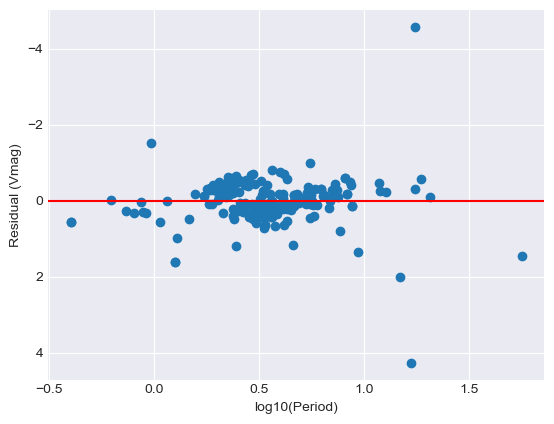

In [31]:
# residuals check
resid = V - pl_model(logP, a, b)

plt.figure()
plt.scatter(logP, resid)
plt.axhline(0, color="red")
plt.xlabel("log10(Period)")
plt.ylabel("Residual (Vmag)")
plt.gca().invert_yaxis()   # optional

In [33]:
# Reduced chi-squared for the P–L fit
sigma = 0.05   # assume 0.05 mag uncertainty per star (you can tweak this)
dof = len(resid) - 2   # number of data points minus number of parameters (a, b)

chi2 = np.sum((resid / sigma)**2)
red_chi2 = chi2 / dof

print(f"Reduced chi^2 = {red_chi2:.2f}")

Reduced chi^2 = 162.93
